### IMPORTACIÓN DE LAS LIBRERIAS

In [2]:
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### LECTURA DEL DATASET Y EDA

#### LECTURA DATASET

In [4]:
df = pd.read_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\Machine_Learning_Project\src\data\raw\healthcare-dataset-stroke-data.csv', index_col=0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Con un *df.info()* observo que existen valores vacíos (NaN) en la columna *bmi*. Más adelante trataré estos valores. También veo que existen varias columnas cuyos datos son de tipo *object*, los cuales también trataré más adelante.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [6]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Con *df.describe()* observo que no parece que haya nada fuera de lo normal, salvo algún posible outlier en la columna *avg_glucose_level* y en la columna *bmi*. Respecto a esta última tendré que ver como quedan sus datos una vez tratados los valores *NaN* que contiene.

In [4]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


#### EDA

In [5]:
# Variables numéricas

variables = [variable for variable in df.columns if variable not in ['id','stroke']]

conts = ['age','avg_glucose_level','bmi']

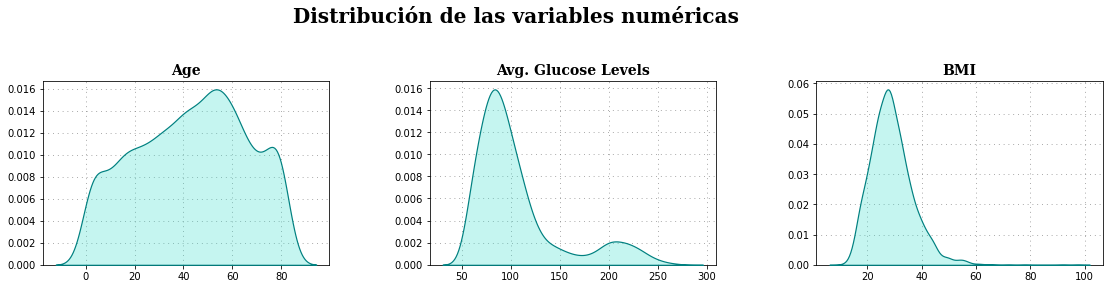

In [6]:
# Subplots de las 3 variables numéricas no binarias

fig = plt.figure(figsize=(19,12))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

background_color = "white"

plot = 0
for feature in conts:
        sns.kdeplot(df[feature], ax=locals()["ax"+str(plot)], color='turquoise', shade=True, linewidth=1.2, ec='teal', alpha=0.3, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1

# AGE
ax0.set_title('Age', loc='center', fontsize=14, fontweight='heavy', fontfamily='serif')
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax0.set_ylabel('')
ax0.set_xlabel('')

# AVG_GLUCOSE_LEVEL
ax1.set_title('Avg. Glucose Levels', loc='center', fontsize=14, fontweight='heavy', fontfamily='serif')
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax1.set_ylabel('')
ax1.set_xlabel('')

# BMI
ax2.set_title('BMI', loc='center', fontsize=14, fontweight='heavy', fontfamily='serif')
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.set_ylabel('')
ax2.set_xlabel('')

ax0.text(85, 0.022, 'Distribución de las variables numéricas', fontsize=20, fontweight='heavy', fontfamily='serif');

In [7]:
stroke = df[df['stroke'] == 1]
no_stroke = df[df['stroke'] == 0]

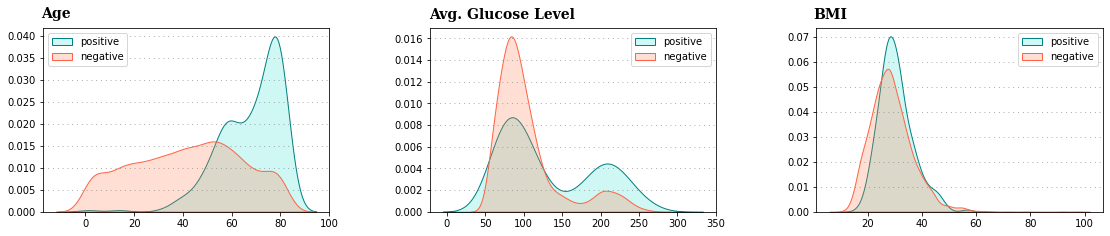

In [8]:
# Subplots de las 3 variables numéricas no binarias en base a la target

fig = plt.figure(figsize=(19,12))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

background_color = "white"
fig.patch.set_facecolor(background_color)

# AGE
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(stroke["age"])
negative = pd.DataFrame(no_stroke["age"])
sns.kdeplot(positive["age"], ax=ax0,color="turquoise", shade=True, ec='teal', label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="coral", shade=True, ec='tomato', label="negative")
ax0.set_ylabel('')    
ax0.set_xlabel('')
ax0.text(-18, 0.044, 'Age', fontsize=14, fontweight='heavy', fontfamily='serif')
ax0.legend(loc=2)

# AVG_GLUCOSE_LEVEL
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(stroke["avg_glucose_level"])
negative = pd.DataFrame(no_stroke["avg_glucose_level"])
sns.kdeplot(positive["avg_glucose_level"], ax=ax1, color="turquoise", ec='teal', shade=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax1, color="coral", ec='tomato', shade=True, label="negative")
ax1.text(-23, 0.0178, 'Avg. Glucose Level', fontsize=14, fontweight='heavy', fontfamily='serif')
ax1.set_ylabel('')    
ax1.set_xlabel('')
ax1.legend(loc=0)

# BMI
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(stroke["bmi"])
negative = pd.DataFrame(no_stroke["bmi"])
sns.kdeplot(positive["bmi"], ax=ax2,color="turquoise", ec='teal', shade=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax2, color="coral", ec='tomato', shade=True, label="negative")
ax2.text(-0.06, 0.077, 'BMI', fontsize=14, fontweight='heavy', fontfamily='serif')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax2.legend(loc=0);

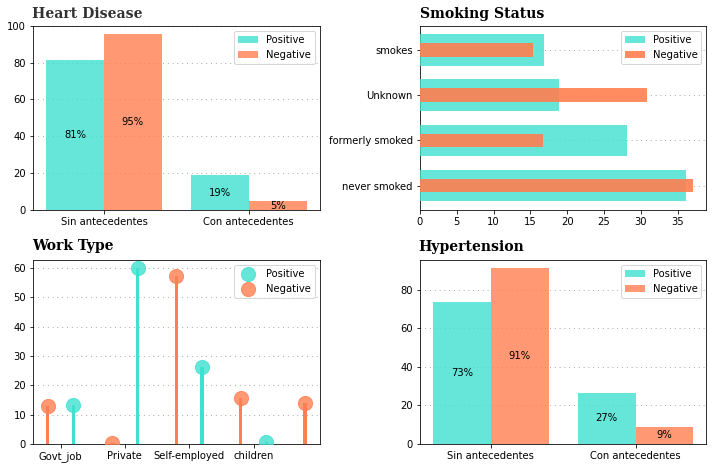

In [9]:
# Subplot con el resto de variables en base a la target

fig = plt.figure(figsize=(19,12))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

background_color = "white"
fig.patch.set_facecolor(background_color)


# HEART DISEASE
positive = pd.DataFrame(stroke["heart_disease"].value_counts())
positive["Percentage"] = positive["heart_disease"].apply(lambda x: x/sum(positive["heart_disease"])*100)
negative = pd.DataFrame(no_stroke["heart_disease"].value_counts())
negative["Percentage"] = negative["heart_disease"].apply(lambda x: x/sum(negative["heart_disease"])*100)

x = np.arange(len(positive))
ax0.text(-0.3, 104, 'Heart Disease', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax0.bar(x, height=positive["Percentage"], zorder=3, color="turquoise", width=0.4, label='Positive', alpha=0.8)
ax0.bar(x+0.4, height=negative["Percentage"], zorder=3, color="coral", width=0.4, label='Negative', alpha=0.8)
ax0.set_xticks(x + 0.4 / 2)
ax0.set_xticklabels(['Sin antecedentes','Con antecedentes'])
ax0.legend()
for i,j in zip([0, 1], positive["Percentage"]):
    ax0.annotate(f'{j:0.0f}%',xy=(i, j/2), color='black', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax0.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='black', horizontalalignment='center', verticalalignment='center')


# SMOKING STATUS
positive = pd.DataFrame(stroke["smoking_status"].value_counts())
positive["Percentage"] = positive["smoking_status"].apply(lambda x: x/sum(positive["smoking_status"])*100)
negative = pd.DataFrame(no_stroke["smoking_status"].value_counts())
negative["Percentage"] = negative["smoking_status"].apply(lambda x: x/sum(negative["smoking_status"])*100)

ax1.text(0, 3.7, 'Smoking Status', fontsize=14, fontweight='heavy', fontfamily='serif')
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax1.barh(positive.index, positive['Percentage'], color="turquoise", zorder=3, height=0.7, label='Positive', alpha=0.8)
ax1.barh(negative.index, negative['Percentage'], color="coral", zorder=3, height=0.3, label='Negative', alpha=0.9)
ax1.legend()


# WORK TYPE
positive = pd.DataFrame(stroke["work_type"].value_counts())
positive["Percentage"] = positive["work_type"].apply(lambda x: x/sum(positive["work_type"])*100)
positive = positive.sort_index()

negative = pd.DataFrame(no_stroke["work_type"].value_counts())
negative["Percentage"] = negative["work_type"].apply(lambda x: x/sum(negative["work_type"])*100)
negative = negative.sort_index()

ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(np.arange(len(positive.index))+0.4, height=positive["Percentage"], zorder=3, color="turquoise", width=0.05)
ax2.scatter(np.arange(len(positive.index))+0.4, positive["Percentage"], zorder=3,s=200, color="turquoise", label='Positive', alpha=0.8)
ax2.bar(negative.index, height=negative["Percentage"], zorder=3, color="coral", width=0.05)
ax2.scatter(negative.index, negative["Percentage"], zorder=3,s=200, color="coral", label='Negative', alpha=0.8)
ax2.set_xticks(np.arange(len(positive.index))+0.4 / 2)
ax2.set_xticklabels(list(positive.index),rotation=0)
ax2.text(-0.25, 66, 'Work Type', fontsize=14, fontweight='heavy', fontfamily='serif')
ax2.legend()


# HYPERTENSION
positive = pd.DataFrame(stroke["hypertension"].value_counts())
positive["Percentage"] = positive["hypertension"].apply(lambda x: x/sum(positive["hypertension"])*100)

negative = pd.DataFrame(no_stroke["hypertension"].value_counts())
negative["Percentage"] = negative["hypertension"].apply(lambda x: x/sum(negative["hypertension"])*100)

x = np.arange(len(positive))
ax3.text(-0.3, 100, 'Hypertension', fontsize=14, fontweight='heavy', fontfamily='serif')
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, color="turquoise", width=0.4, label='Positive', alpha=0.8)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, color="coral", width=0.4, label='Negative', alpha=0.8)
ax3.set_xticks(x + 0.4 / 2)
ax3.set_xticklabels(['Sin antecedentes','Con antecedentes'])
ax3.legend()
for i,j in zip([0, 1], positive["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2), color='black', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='black', horizontalalignment='center', verticalalignment='center');

### TRATAMIENTO DE LOS DATOS

Lo primero que hago es obtener un recuento de los valores de las columnas que parecen contener datos binarios.

In [10]:
print('Gender: \n', df['gender'].value_counts())
print('-'*33)
print('Ever married: \n', df['ever_married'].value_counts())
print('-'*33)
print('Hypertension: \n', df['hypertension'].value_counts())
print('-'*33)
print('Heart disease: \n', df['heart_disease'].value_counts())
print('-'*33)
print('Stroke: \n', df['stroke'].value_counts())

Gender: 
 Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
---------------------------------
Ever married: 
 Yes    3353
No     1757
Name: ever_married, dtype: int64
---------------------------------
Hypertension: 
 0    4612
1     498
Name: hypertension, dtype: int64
---------------------------------
Heart disease: 
 0    4834
1     276
Name: heart_disease, dtype: int64
---------------------------------
Stroke: 
 0    4861
1     249
Name: stroke, dtype: int64


#### Tratamiento de las variables categóricas para convertirlas en variables númericas con las que poder trabajar.

En el caso de la columna *ever_married* no hay problema: contiene valores *Yes* o *No* por lo que convierto los primeros en 1s y los segundos en 0s.

In [6]:
df['married'] = np.where(df['ever_married']=='Yes', 1,0)
df.drop(columns='ever_married', inplace=True)
df['married'].value_counts()

1    3353
0    1757
Name: married, dtype: int64

En cuanto a la columna *gender*, que contiene tres categorías, como sólo existe un valor en la categoria *Other*, la sumo a la categoria *Male*. Convierto las categorías *Female* y *Male* en 1s y 0s respectivamente.

In [7]:
df['gender'] = np.where(df['gender']=='Female', 1,0)
df['gender'].value_counts()

1    2994
0    2116
Name: gender, dtype: int64

En la columna *Residence_type* hay dos categorías: *Urban* y *Rural*. Creo una nueva columna *residence_urban* que contendrá 1s en los casos en los que se cumpla la variable y 0s en aquellos casos en los que no.

In [8]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [9]:
df['residence_urban'] = np.where(df['Residence_type']=='Urban', 1,0)
df.drop(columns='Residence_type', inplace=True)
df['residence_urban'].value_counts()

1    2596
0    2514
Name: residence_urban, dtype: int64

Para la columna *work_type* aplico valores en función de la correlación que tienen las distintas opciones con la variable *target*.

In [15]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [10]:
# Creo un nuevo dataframe diviendo la columna work_types en tantas otras como categorías contiene. Estas nuevas columnas contienen 0s y 1s.
df_work = pd.get_dummies(df['work_type'])

# Creo un nuevo dataframe que sólo contiene la target para, más adelante, poder comparar los datos con los diferentes tipos de trabajo.
df_stroke = df['stroke']

# Hago un merge de las columnas creadas expresamente para el tratamiento de la feature "work_type".
# Con este paso tengo en un mismo dataset las diferentes categorías de work_type y la target stroke.
df_work_merge = pd.merge(df_work, df_stroke, how='inner', on='id')
df_work_merge.head()

,Govt_job,Never_worked,Private,Self-employed,children,stroke
id,,,,,,
9046,0,0,1,0,0,1
51676,0,0,0,1,0,1
31112,0,0,1,0,0,1
60182,0,0,1,0,0,1
1665,0,0,0,1,0,1


<AxesSubplot:>

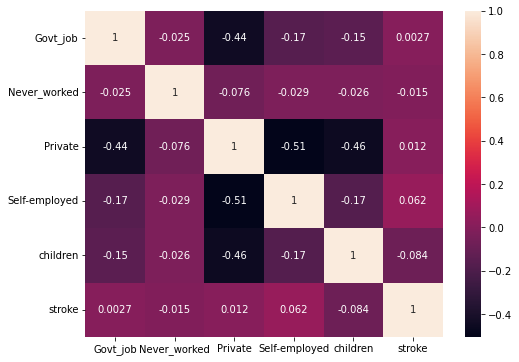

In [17]:
# Genero un mapa de calor para poder ver la correlación de los tipos de trabajo con la target.
plt.figure(figsize=(8,6))
sns.heatmap(df_work_merge.corr(), annot=True)

In [11]:
# Ahora ya puedo asignar un valor númerico a los diferentes tipos de trabajo que se ajusta a los datos en función de su correlación con la target.
work_type_dict = {'children': -2, 'Never_worked': -1, 'Govt_job': 0, 'Private': 1, 'Self-employed': 2}
df['work'] = df['work_type'].replace(work_type_dict)
df.drop(columns='work_type', inplace=True)

En la columna *smoking_status* existe una categoría *Unknown* en la que se recogen los datos para aquellas instancias sobre las que no se tiene información. Como se tiene información al respecto, decido aplicarle un valor de 1 y darle un valor de 0 a la categoría *never smoked*.

In [12]:
smoking_status_dict = {'Unknown': 1, 'formerly smoked': 2, 'never smoked': 0, 'smokes': 3}
df['smoke'] = df['smoking_status'].replace(smoking_status_dict)
df.drop(columns='smoking_status', inplace=True)

### TRATAMIENTO DEL RESTO DE VARIABLES

Decido tratar los datos *NaN* de la columna *bmi* aplicando un *KNNImputer*.

In [13]:
imputer = KNNImputer(n_neighbors = 6)
df['bmi'] = imputer.fit_transform(np.array(df['bmi']).reshape(-1,1))

Redondeo de la variable *age*.

In [14]:
df['age'] = df['age'].apply(lambda x: round(x))

Escalado de variables.

In [15]:
a_escalar = ['age','avg_glucose_level', 'bmi']
df.loc[:,a_escalar] = MinMaxScaler().fit_transform(df.loc[:,a_escalar])

#### HEATMAP

In [16]:
df = df[['age', 'avg_glucose_level', 'hypertension', 'heart_disease', 'married', 'work', 'bmi', 'smoke', 'residence_urban', 'gender', 'stroke']]

<AxesSubplot:>

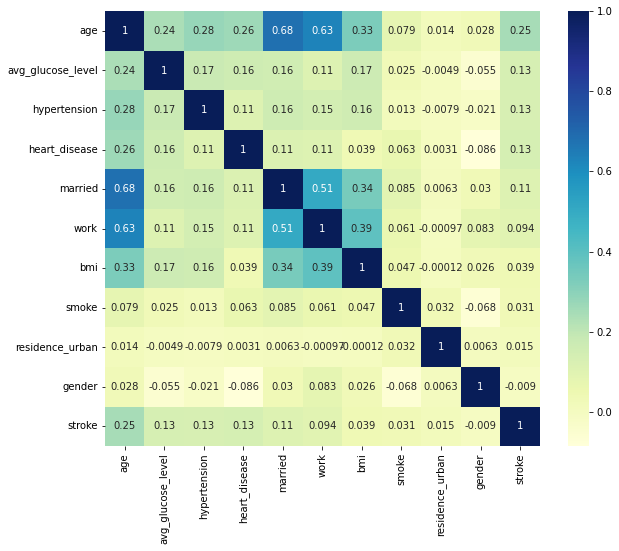

In [17]:
# Heatmap para ver la corrlación de las variables con la target
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), square=True, annot=True, cmap='YlGnBu')

### CREACIÓN DE LOS DATASET LIMPIOS PARA EL PROCESO DE CREACIÓN DEL MODELO

In [45]:
# Dataset final a partir del cual crearemos los dataset de test y train
data = df.copy()
data.drop(columns=['work', 'bmi', 'smoke', 'residence_urban', 'gender'], inplace=True)
data.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\processed\data.csv')

In [46]:
# Dataset de test para realizar las comprobaciones del modelo entrenado
test = data.copy()
test.sort_values(by='id', inplace=True)
test = test.iloc[:600, :]
target = test['stroke']
test.drop(columns=['stroke'], inplace=True)
test.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\processed\test.csv')

In [47]:
# Dataset con la target que le pasaremos al modelo cuando comprobemos qué tal generaliza con el dataset de test
target.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\processed\target.csv')

In [48]:
# Dataset de train con el que entrenaremos al modelo
train = data.copy()
train.sort_values(by='id', inplace=True)
train = train.iloc[601: , :]
train.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\processed\train.csv') 

### BALANCED BAGGING CLASSIFIER

In [22]:
# Función para mostrar los resultados obtenidos
def mostrar_resultados(target, y_pred):
    conf_matrix = confusion_matrix(target, y_pred)
    plt.figure(figsize=(7,4))
    sns.heatmap(conf_matrix, annot=True)
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    print (classification_report(target, y_pred))

In [49]:
# División del dataset en las variables X e y
X = train.drop(columns='stroke')
y = train['stroke']

In [50]:
# Aplicación de un oversample para balancear las muestras de positivos
oversample = RandomOverSampler(sampling_strategy=0.60)

X_over, y_over = oversample.fit_resample(X, y)

print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_over)))

Original dataset shape Counter({0: 4291, 1: 218})
Resampled dataset shape Counter({0: 4291, 1: 2574})


In [52]:
# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.20, random_state=42)

In [73]:
# Preparación de las variables para el gridsearch del random forest
rf = RandomForestClassifier()

n_estimators = np.arange(1, 10, 1)
max_depth = np.arange(1, 6, 1)
min_samples_split = np.arange(1, 8, 1)
min_samples_leaf = np.arange(1, 8, 1)
bootstrap = [True, False]

grid_rf = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
        }

In [74]:
# Aplicación del gridsearch para el random forest
gs_rf = GridSearchCV(rf, param_grid=grid_rf, cv=10, scoring='recall',  n_jobs = -1)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': array([1, 2, 3, 4, 5]),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7]),
                         'min_samples_split': array([1, 2, 3, 4, 5, 6, 7]),
                         'n_estimators': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='recall')

In [75]:
rf_best = gs_rf.best_params_
rf_best

{'bootstrap': True,
 'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 1}

In [76]:
# Preparación de las variables para el gridsearch del balanced bagging
bbc_clf = BalancedBaggingClassifier()

n_estimators = np.arange(2, 12, 2)
bootstrap = [True, False]
replacement = [True, False]
# sampling_strategy = np.arange(0.3, 1, 0.1)

grid_bbc = {
        'n_estimators': n_estimators,
        'bootstrap': bootstrap,
        'replacement': replacement,
        # 'sampling_strategy': sampling_strategy
        }

In [77]:
# Aplicación del gridsearch para el balanced bagging
gs_bbc = GridSearchCV(bbc_clf, param_grid=grid_bbc, cv=10, scoring='recall',  n_jobs = -1)
gs_bbc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BalancedBaggingClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'n_estimators': array([ 2,  4,  6,  8, 10]),
                         'replacement': [True, False]},
             scoring='recall')

In [78]:
bbc_best = gs_bbc.best_params_
bbc_best

{'bootstrap': True, 'n_estimators': 8, 'replacement': False}

              precision    recall  f1-score   support

           0       0.90      0.67      0.77       860
           1       0.61      0.88      0.72       513

    accuracy                           0.75      1373
   macro avg       0.76      0.77      0.75      1373
weighted avg       0.79      0.75      0.75      1373



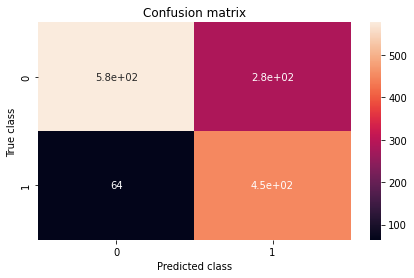

In [183]:
# Creación del modelo con BalancedBagginClassifier en base a un RandomForestClassifier en función de los parámetros obtenidos con los GridSearchCV
bbc = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(max_depth=4, bootstrap=True, min_samples_leaf=1, min_samples_split=3, n_estimators=2, random_state=42),
                                bootstrap=True,
                                replacement=True,
                                random_state=42,
                                n_estimators=10)

# Entrenamos el modelo
bbc.fit(X_train, y_train)

# Realizamos las predicciones
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

In [184]:
# Pasamos el modelo por el dataset de test para ver qué tal generaliza
predicciones = bbc.predict(test)
c_mat = confusion_matrix(target, predicciones)
c_mat

array([[397, 172],
       [  1,  30]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      0.70      0.82       569
           1       0.15      0.97      0.26        31

    accuracy                           0.71       600
   macro avg       0.57      0.83      0.54       600
weighted avg       0.95      0.71      0.79       600



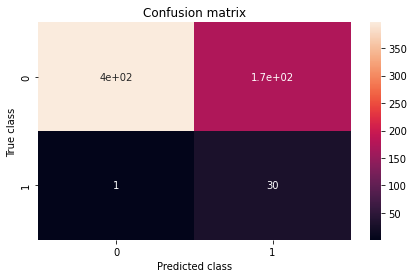

In [185]:
mostrar_resultados(target, predicciones)

In [82]:
# Fnción para guardar el modelo
def save_file(model, file_name):
    with open(file_name, "wb") as exit_file:
        pickle.dump(model, exit_file)

In [83]:
# save_file(bbc, r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\model\my_model')